## **Import libraries and packages**

In [ ]:
# %tensorflow_version 2.x

# import tensorflow and tensorflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# import ImageDataGenerator and the related functions required for processing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# import optimizers
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop

# import statements for building and loading the model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.models import model_from_json

# import statements for callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# import statements for initlializers and regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2

# import statements for one-hot encoding, model plotting
from tensorflow.keras.utils import to_categorical, plot_model

# import statements for loading ResNet50 from keras
from tensorflow.keras.applications import resnet50
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input

# import statements for scikit-learn
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tensorflow.keras.layers.experimental import preprocessing

# import scipy
import scipy.misc

# import os for file access
import os 

# import glob
import glob

# import numpy, pandas
import numpy as np
import pandas as pd

# import opencv
import cv2

# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# import zipfile for unzipping the data
import zipfile

# import csv to access the csv files
import csv

# import drive to access the data from GDrive
from google.colab import drive

# import seaborn
import seaborn as sns

# import time
from time import time

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## **Load the dataset**

In [ ]:
drive.mount('/content/drive')

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ChIA Images_6.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
train_dir = '/tmp/ChIA Images_6/train/'
val_dir = '/tmp/ChIA Images_6/validation/'
test_dir = '/tmp/ChIA Images_6/test/'

## **Data Augmentation**

In [ ]:
training_batch_size = 16
validation_batch_size = 16
def get_images(img_size, preprocessing):

  
  train_datagen = ImageDataGenerator(rotation_range=20,
                              horizontal_flip= True,
                              height_shift_range=0.1,
                              width_shift_range=0.1,
                              shear_range=0.2,
                              zoom_range=0.2,
                              fill_mode="nearest",
                              preprocessing_function = preprocessing)
  
  datagen = ImageDataGenerator(preprocessing_function= preprocessing)
  
  train_datagen = train_datagen.flow_from_directory(train_dir,
                                            batch_size= training_batch_size,
                                            shuffle= True,
                                            target_size = (img_size, img_size),
                                            classes = ['Appealing', 'Non-appealing'])
  
  val_datagen = datagen.flow_from_directory(val_dir,
                                            batch_size= validation_batch_size,
                                            shuffle= False,
                                            target_size = (img_size, img_size),
                                            classes = ['Appealing', 'Non-appealing'])
  
  test_datagen = datagen.flow_from_directory(test_dir,
                                            batch_size= validation_batch_size,
                                            shuffle= False,
                                            target_size = (img_size, img_size),
                                            classes = ['Appealing', 'Non-appealing'])
  
  return train_datagen, val_datagen, test_datagen

In [ ]:
train_datagen, val_datagen, test_datagen = get_images(224, preprocessing= resnet50.preprocess_input)

Found 530 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [ ]:
def visualize_training(history, epochs):
  fig = plt.figure()
  
  #plt.subplot(1,2,1)
  plt.plot(history.history['accuracy']);
  plt.plot(history.history['val_accuracy'])
  plt.title("Model Accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  #plt.figsize()
  label_1 = "{:.2f}".format(history.history['accuracy'][-1])
  label_2 = "{:.2f}".format(history.history['val_accuracy'][-1])
  plt.annotate(label_1, (epochs-1,history.history['accuracy'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.annotate(label_2, (epochs-1,history.history['val_accuracy'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.legend(['training', 'validation'], loc='upper left')

  fig = plt.figure()

  #plt.subplot(1,2,2)
  plt.plot(history.history['loss']);
  plt.plot(history.history['val_loss'])
  plt.title("Model Loss")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  label_3 = "{:.2f}".format(history.history['loss'][-1])
  label_4 = "{:.2f}".format(history.history['val_loss'][-1])
  plt.annotate(label_3, (epochs-1,history.history['loss'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.annotate(label_4, (epochs-1,history.history['val_loss'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.legend(['training', 'validation'], loc='upper left')

  plt.show()

In [ ]:
def print_classification_report(model, data_gen, batch_size):
  true_labels = data_gen.labels
  data_gen.reset()
  predicted_labels = model.predict(data_gen, steps = np.ceil(len(true_labels)/batch_size))
  #print(list( np.argmax(a) for a in predicted_labels), true_labels)
  print(classification_report(true_labels, list( np.argmax(a) for a in predicted_labels)))
  print("Confusion Matrix:\n ",confusion_matrix(true_labels,list( np.argmax(a) for a in predicted_labels)))

## **Build the model**

In [ ]:
resnet_base = resnet50.ResNet50(weights='imagenet', include_top= False, input_shape= (224, 224, 3))

In [ ]:
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model = models.Sequential()
model.add(resnet_base)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(2, activation= 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2

In [ ]:
resnet_base.trainable = False
resnet_base.training = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2

## **Compile the model**

In [ ]:
learning_rate = 1e-4
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov= False), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks_list = [keras.callbacks.ModelCheckpoint(
        filepath = '/content/resnet-model.h5',
        monitor = 'val_accuracy',
        verbose=1,
        save_best_only = True),
        keras.callbacks.EarlyStopping(
            monitor= 'val_accuracy',
            patience = 6,
            mode = 'max',
            verbose= 1
        )]

## **Train the model**

In [ ]:
n_epochs = 5
history = model.fit(train_datagen,
                             steps_per_epoch=len(train_datagen.filenames)//training_batch_size,
                             epochs=n_epochs,
                             validation_data=val_datagen,
                             validation_steps = int(np.ceil(len(val_datagen.filenames)/validation_batch_size)))

Epoch 1/5
16/33 [=============>................] - ETA: 15s - loss: 1.3980 - accuracy: 0.3933

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (172478285 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


33/33 [==============================] - 56s 1s/step - loss: 1.2986 - accuracy: 0.4249 - val_loss: 0.8309 - val_accuracy: 0.4143
Epoch 2/5
33/33 [==============================] - 44s 1s/step - loss: 0.8979 - accuracy: 0.5620 - val_loss: 0.6355 - val_accuracy: 0.6571
Epoch 3/5
33/33 [==============================] - 44s 1s/step - loss: 0.7310 - accuracy: 0.6673 - val_loss: 0.5638 - val_accuracy: 0.7286
Epoch 4/5
33/33 [==============================] - 44s 1s/step - loss: 0.6467 - accuracy: 0.6891 - val_loss: 0.5120 - val_accuracy: 0.7524
Epoch 5/5
33/33 [==============================] - 44s 1s/step - loss: 0.7711 - accuracy: 0.6653 - val_loss: 0.4813 - val_accuracy: 0.7571


## **Fine tune the model**

In [ ]:
resnet_base.trainable = True
set_trainable = False
for layer in resnet_base.layers:
  if 'conv5_block3' in layer.name:
    set_trainable= True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable= False

In [ ]:
for layer in resnet_base.layers[165:]:
  if isinstance(layer, keras.layers.BatchNormalization):
    layer.trainable = False

In [ ]:
for i, layer in enumerate(resnet_base.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
learning_rate = 1e-4
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov = False), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2

In [ ]:
n_epochs = 40
history = model.fit(train_datagen,
                             steps_per_epoch=len(train_datagen.filenames)//training_batch_size,
                             epochs=n_epochs,
                             validation_data=val_datagen,
                             validation_steps=int(np.ceil(len(val_datagen.filenames)/validation_batch_size)),
                             callbacks=callbacks_list,
                             verbose= 1)

Epoch 1/40
26/33 [======================>.......] - ETA: 6s - loss: 0.7097 - accuracy: 0.7391

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (172478285 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


33/33 [==============================] - 48s 1s/step - loss: 0.7168 - accuracy: 0.7274 - val_loss: 0.4762 - val_accuracy: 0.7667

Epoch 00001: val_accuracy improved from -inf to 0.76667, saving model to /content/new-resnet-model_2.h5
Epoch 2/40
33/33 [==============================] - 43s 1s/step - loss: 0.6338 - accuracy: 0.7098 - val_loss: 0.4644 - val_accuracy: 0.7667

Epoch 00002: val_accuracy did not improve from 0.76667
Epoch 3/40
33/33 [==============================] - 43s 1s/step - loss: 0.5484 - accuracy: 0.7556 - val_loss: 0.4524 - val_accuracy: 0.7905

Epoch 00003: val_accuracy improved from 0.76667 to 0.79048, saving model to /content/new-resnet-model_2.h5
Epoch 4/40
33/33 [==============================] - 42s 1s/step - loss: 0.6702 - accuracy: 0.6983 - val_loss: 0.4510 - val_accuracy: 0.7857

Epoch 00004: val_accuracy did not improve from 0.79048
Epoch 5/40
33/33 [==============================] - 42s 1s/step - loss: 0.6847 - accuracy: 0.6999 - val_loss: 0.4524 - val_acc

## **Visualize the training process**

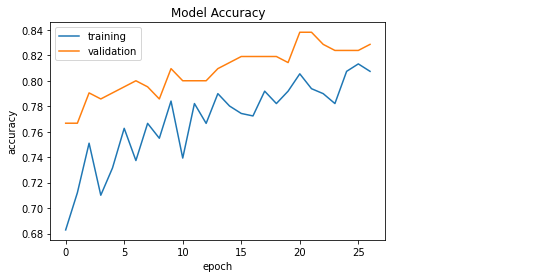

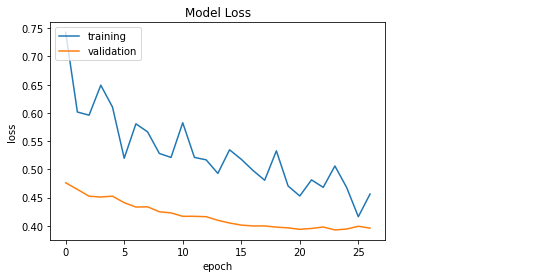

In [ ]:
visualize_training(history, n_epochs)

## **Load the saved model**

In [ ]:
loaded_model = load_model('/content/resnet-model.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2

## **Evaluate the model**

In [ ]:
_, evaluate_datagen, test_datagen = get_images(224, preprocessing= resnet50.preprocess_input)

Found 530 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [ ]:
model_result = loaded_model.evaluate(
    evaluate_datagen,
    steps= None)

14/14 [==============================] - 8s 481ms/step - loss: 0.3937 - accuracy: 0.8381


In [ ]:
test_report = loaded_model.evaluate(
    test_datagen,
    steps= None
)

6/6 [==============================] - 8s 1s/step - loss: 0.4166 - accuracy: 0.8000


## **Classification Report**

In [ ]:
print_classification_report(loaded_model, evaluate_datagen,  validation_batch_size)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       140
           1       0.77      0.73      0.75        70

    accuracy                           0.84       210
   macro avg       0.82      0.81      0.82       210
weighted avg       0.84      0.84      0.84       210

Confusion Matrix:
  [[125  15]
 [ 19  51]]


In [ ]:
print_classification_report(loaded_model, test_datagen, validation_batch_size)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        58
           1       0.75      0.66      0.70        32

    accuracy                           0.80        90
   macro avg       0.79      0.77      0.78        90
weighted avg       0.80      0.80      0.80        90

Confusion Matrix:
  [[51  7]
 [11 21]]
